Esse programa tem o objetivo de:


receber o path de um arquivo de imagem
transformar essa imagem .png em PIL Image

Extrair o tensores dessa PIL Image

Analisar as características dessa imagem pelos tensores
voltar um array com as caracteristicas das imagem

calcular da base de dados, os 5 icones que mais se assemelham a imagem que o programa recebeu


In [1]:
import os

import json

import pandas as pd
import numpy as np

import torch
from torchvision.transforms import v2
from PIL import Image

import torchvision.models as models


from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
def  ler_imagem(path_imagem):

    imagem = Image.open(path_imagem).convert('RGB')
    
    return imagem
    

In [3]:
def tensor_imagem(imagem):

    img = v2.Compose([
                    v2.Resize((224, 224)),
                    v2.ToImage(), 
                    v2.ToDtype(torch.float32, scale=True),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        
    tensor_imagem = img(imagem)

    return tensor_imagem

In [4]:
def analisar_tensor_imagem(tensor_imagem):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Torch device: {device}\n")

    torch.cuda.empty_cache()

    model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
    model = torch.nn.Sequential(*(list(model.children())[:-1]))

    model.to(device).eval()

    tensor_imagem = tensor_imagem.to(device)

    if tensor_imagem.dim() == 3:
        tensor_imagem = tensor_imagem.unsqueeze(0)
    
    with torch.no_grad():
        features = model(tensor_imagem).squeeze()
        array_caracteristicas = features.cpu().numpy()


    return array_caracteristicas

In [14]:
def ler_dataframe(nome_arquivo_sqlite = 'icons-database.sqlite'):

        engine = create_engine(f'sqlite:///{nome_arquivo_sqlite}')
        nome_data_base = pd.read_sql('data', engine)
        nome_data_base['Array características'] = nome_data_base['Array características'].apply(lambda x: np.array(json.loads(x)))
        return nome_data_base

In [16]:
def comparador(array_caracteristicas_imagem, data_base, qntd_imagens_similares = 5):
    
    distances = [euclidean(array_caracteristicas_imagem, c) for c in data_base['Array características']]

    alike_indexes = np.argsort(distances)
    top_alike_indexes = alike_indexes[:qntd_imagens_similares]

    return top_alike_indexes


In [25]:
def visualizar_similares(indices_similares, data_base):

    plt.figure(figsize=(15, 5))
 
    for i, idx in enumerate(indices_similares):
        img = (Image.open(data_base['Png Path'][idx]))
        plt.subplot(1, len(indices_similares), i + 1)
        plt.imshow(img)
        plt.title(f'Icone: {data_base['Nome'][idx]}')
        plt.axis('off')
    plt.show()

In [8]:
def main(path_imagem, nome_arquivo_sqlite = "icons-database.sqlite", qntd_imagens_similares = 5):

    imagem = ler_imagem(path_imagem)

    tensor = tensor_imagem(imagem)

    caracteristicas = analisar_tensor_imagem(tensor)

    data_base = ler_dataframe(nome_arquivo_sqlite)

    idx_semelhantes = comparador(caracteristicas, data_base, qntd_imagens_similares)

    alike_icons_paths = [data_base['Svg Path'][idx] for idx in idx_semelhantes]

    print("\nPath dos icones similares:")
    for path in alike_icons_paths:
        print("\n" + path +"\n")

    visualizar_similares(idx_semelhantes, data_base)


Torch device: cuda


Path dos icones similares:

icons-base\grommet_icons\default\projects.svg


icons-base\grommet_icons\default\risk.svg


icons-base\grommet_icons\default\more_vertical.svg


icons-base\grommet_icons\default\drag.svg


icons-base\grommet_icons\default\clone.svg



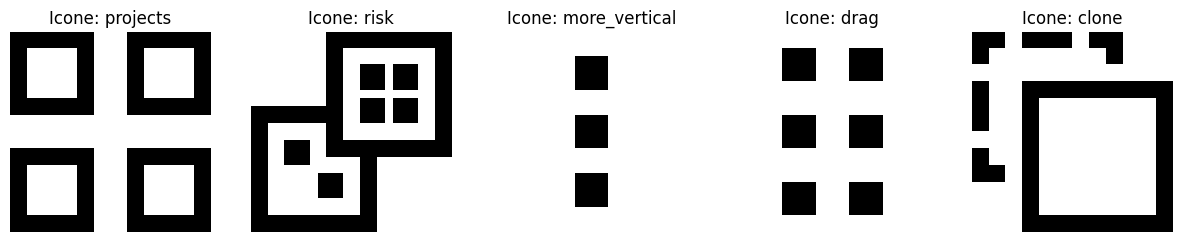

In [28]:
main('teste05.png')